# Predict Energy Behavior of Prosumers

## Introduction
what is the motivation behind it & How did we get the dataset

Questions to Address

* Business Classification:
    * Predict whether the prosumer is a business or not based on the features. 
* Electricity Prices:
    * Predict the price of electricity and what features are having an impact on this price

In [14]:
# import necessary libraries
library(dplyr)
library(reshape2)
library(corrplot)
library(rjson)
library(glmnet)
library(MASS)
library(caret)


Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select


Loading required package: ggplot2

Loading required package: lattice



## Data Exploration

e.g., summary table / correlation matrix —> pick up 5 good features and plot cm

In [2]:
# load the data
# client data
client <- read.csv('data/client.csv')

# county_id_to_name_map data
county_id_to_name <- fromJSON(file="county_id_to_name_map.json")
county_id_to_name <- as.data.frame(county_id_to_name)

# electricity prices data
electricity <- read.csv('data/electricity_prices.csv')

# gas prices data
gas <- read.csv('data/gas_prices.csv')

# drop the date and forecast_date column
client = subset(client, select = -c(date))
electricity = subset(electricity, select = -c(origin_date))
gas = subset(gas, select = -c(origin_date))

electricity = subset(electricity, select = -c(forecast_date))
gas = subset(gas, select = -c(forecast_date))

# merge the three datasets
df <- merge(client, electricity, by = 'data_block_id')
df <- merge(df, gas, by = 'data_block_id')
head(df)

,data_block_id,product_type,county,eic_count,installed_capacity,is_business,euros_per_mwh,lowest_price_per_mwh,highest_price_per_mwh
,<int>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,2,1,0,108,952.89,0,96.99,45.62,46.29
2,2,1,0,108,952.89,0,94.77,45.62,46.29
3,2,1,0,108,952.89,0,93.88,45.62,46.29
4,2,1,0,108,952.89,0,92.25,45.62,46.29
5,2,1,0,108,952.89,0,91.83,45.62,46.29
6,2,1,0,108,952.89,0,98.62,45.62,46.29


In [3]:
prosumer <- read.csv('data/prosumer.csv')
head(prosumer)

,county,is_business,product_type,target,is_consumption,datetime,data_block_id,row_id,prediction_unit_id
,<int>,<int>,<int>,<dbl>,<int>,<chr>,<int>,<int>,<int>
1,0,0,1,2.087,0,2023-03-31 00:00:00,576,1821840,0
2,0,0,1,1133.353,1,2023-03-31 00:00:00,576,1821841,0
3,0,0,2,0.000,0,2023-03-31 00:00:00,576,1821842,1
4,0,0,2,18.323,1,2023-03-31 00:00:00,576,1821843,1
5,0,0,3,2.342,0,2023-03-31 00:00:00,576,1821844,2
6,0,0,3,2724.347,1,2023-03-31 00:00:00,576,1821845,2


In [4]:
forecast <- read.csv('data/weather_forecast.csv')
head(forecast)

,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,X10_metre_u_wind_component,X10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,57.6,21.7,2023-03-29 23:00:00+00:00,25,3.072656,1.9813477,0.8783875,1.0000000,1,0.9999987,-4.861672,-0.5292301,576,2023-03-31 00:00:00+00:00,0,0,0,0.0003385534
2,57.6,22.2,2023-03-29 23:00:00+00:00,25,2.684717,1.9613281,0.5744629,1.0000000,1,0.9999987,-3.694436,0.1282406,576,2023-03-31 00:00:00+00:00,0,0,0,0.0003807535
3,57.6,22.7,2023-03-29 23:00:00+00:00,25,2.164453,1.3192383,1.0000000,1.0000000,1,0.9999987,-4.737161,1.0567074,576,2023-03-31 00:00:00+00:00,0,0,0,0.0005037775
4,57.6,23.2,2023-03-29 23:00:00+00:00,25,2.220361,1.2220703,0.9999695,0.8691406,1,0.9999987,-5.812112,1.2803402,576,2023-03-31 00:00:00+00:00,0,0,0,0.0004806509
5,57.6,23.7,2023-03-29 23:00:00+00:00,25,2.269189,1.0853516,0.9954529,1.0000000,1,0.9999987,-5.387063,1.7035580,576,2023-03-31 00:00:00+00:00,0,0,0,0.0003116121
6,57.6,24.2,2023-03-29 23:00:00+00:00,25,2.257227,0.9081055,0.9996643,0.9995117,1,0.9999987,-4.791848,1.5549984,576,2023-03-31 00:00:00+00:00,0,0,0,0.0001456728


In [5]:
history <- read.csv('data/weather_history.csv')
head(history)

,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2023-03-31 00:00:00,1.7,0.5,0,0.00,1005.0,100,56,100,99,4.527778,96,0,0,0,57.6,21.7,577
2,2023-03-31 00:00:00,1.3,0.3,0,0.00,1000.4,100,58,100,99,3.527778,98,0,0,0,57.6,22.2,577
3,2023-03-31 00:00:00,2.1,1.4,0,0.00,1005.7,100,66,100,100,3.777778,101,0,0,0,57.6,22.7,577
4,2023-03-31 00:00:00,1.5,-3.3,0,0.07,982.7,100,76,96,67,17.638889,303,0,0,0,57.6,23.2,577
5,2023-03-31 00:00:00,1.5,0.6,0,0.00,1006.2,100,87,100,100,4.361111,110,0,0,0,57.6,23.7,577
6,2023-03-31 00:00:00,0.7,-4.0,0,0.00,980.7,100,97,89,0,12.833333,296,0,0,0,57.6,24.2,577


In [6]:
weather_station_to_county <- read.csv('data/weather_station_to_county_mapping.csv')
head(weather_station_to_county)

,county_name,longitude,latitude,county
,<chr>,<dbl>,<dbl>,<int>
1,,21.7,57.6,NA
2,,21.7,57.9,NA
3,,21.7,58.2,NA
4,,21.7,58.5,NA
5,,21.7,58.8,NA
6,,21.7,59.1,NA


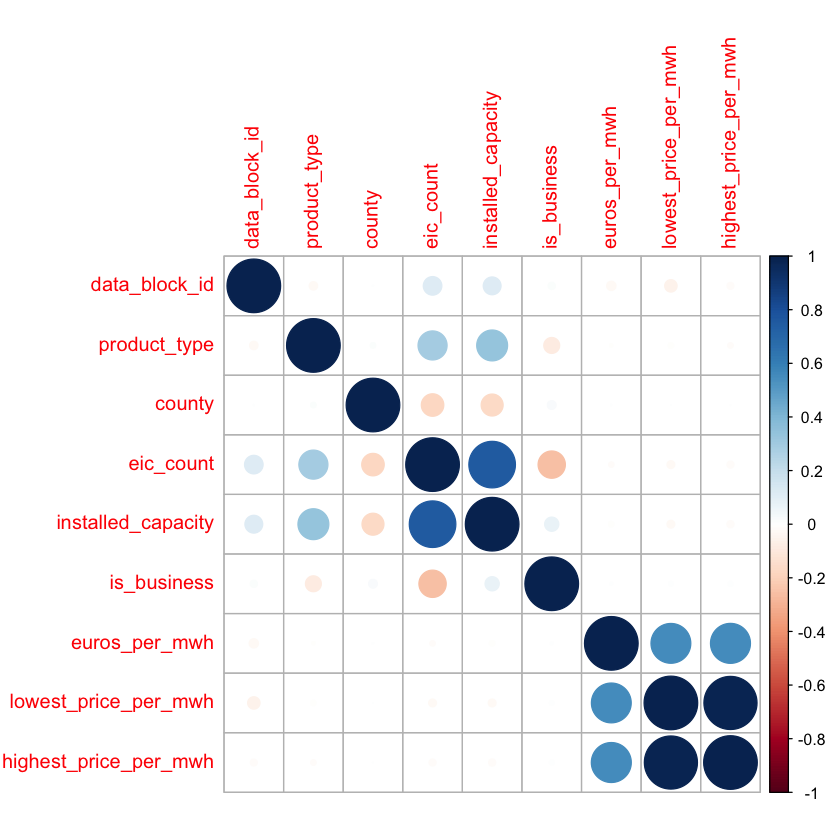

In [17]:
# calculate correlation matrix
correlation_matrix <- cor(df)

# plot the cm
corrplot(correlation_matrix, method = "circle")

## Statistical Analysis

### Logistic Regression

Possible Logistic / Linear Regression Tasks

First Logistic regression task -  Predicting whether the prosumer is a business or not based on the available features. Uses client, electricity and gas CSV's.

Linear Regression - linear regression to predict the euros_per_mwh variable based on other features



In [7]:
#Logistic Regression
model <- glm(is_business ~ euros_per_mwh + lowest_price_per_mwh + installed_capacity + eic_count  +  county + product_type + highest_price_per_mwh, data = df, family = binomial)
summary(model)


#Linear Regression
linear_model <- lm(euros_per_mwh ~ is_business + lowest_price_per_mwh + installed_capacity + eic_count  +  county + product_type + highest_price_per_mwh, data = df)
summary(linear_model)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"



Call:
glm(formula = is_business ~ euros_per_mwh + lowest_price_per_mwh + 
    installed_capacity + eic_count + county + product_type + 
    highest_price_per_mwh, family = binomial, data = df)

Coefficients:
                        Estimate Std. Error  z value Pr(>|z|)    
(Intercept)            8.179e-01  1.934e-02   42.281   <2e-16 ***
euros_per_mwh          3.297e-05  4.917e-05    0.671    0.502    
lowest_price_per_mwh  -7.064e-03  5.365e-04  -13.168   <2e-16 ***
installed_capacity     1.625e-02  5.410e-05  300.357   <2e-16 ***
eic_count             -3.921e-01  1.218e-03 -322.024   <2e-16 ***
county                -9.065e-02  1.149e-03  -78.912   <2e-16 ***
product_type           1.111e+00  8.902e-03  124.796   <2e-16 ***
highest_price_per_mwh  7.350e-03  4.667e-04   15.749   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1389060  on 1005922  degrees of freedom
Residual dev


Call:
lm(formula = euros_per_mwh ~ is_business + lowest_price_per_mwh + 
    installed_capacity + eic_count + county + product_type + 
    highest_price_per_mwh, data = df)

Residuals:
   Min     1Q Median     3Q    Max 
-366.6  -54.6   -5.3   46.8 3647.0 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            2.229e+01  3.548e-01  62.823   <2e-16 ***
is_business           -4.833e-01  2.310e-01  -2.092   0.0364 *  
lowest_price_per_mwh   4.197e-01  1.093e-02  38.401   <2e-16 ***
installed_capacity     7.956e-05  7.121e-05   1.117   0.2638    
eic_count             -1.842e-03  1.212e-03  -1.520   0.1286    
county                 1.017e-02  2.146e-02   0.474   0.6357    
product_type           2.402e-01  9.955e-02   2.413   0.0158 *  
highest_price_per_mwh  8.753e-01  9.497e-03  92.160   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 100.8 on 1005915 degrees of freedom
Multiple R-sq

### Lasso / Ridge

[1] 0.0004425236

7 x 1 sparse Matrix of class "dgCMatrix"
                                 s1
(Intercept)            5.945632e-01
lowest_price_per_mwh   .           
installed_capacity     1.308356e-04
eic_count             -2.455192e-03
county                 8.572165e-04
product_type          -4.142035e-02
highest_price_per_mwh  4.497273e-05

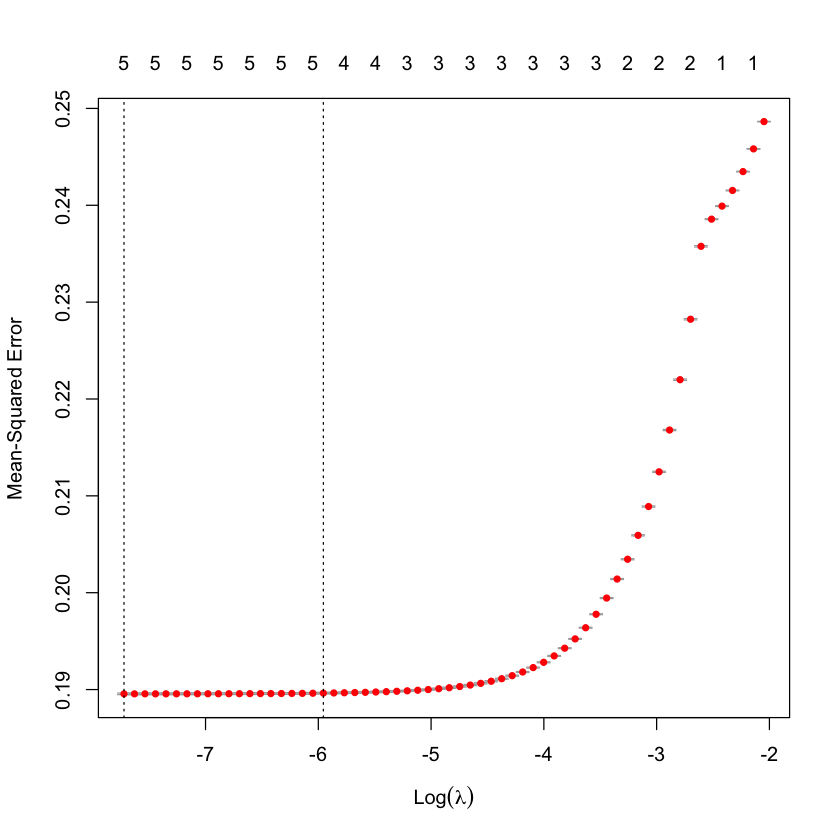

In [10]:
#Lasso
my_df <- df
y <- my_df$is_business
x <- my_df[, c('lowest_price_per_mwh', 'installed_capacity', 'eic_count', 'county', 'product_type', 'highest_price_per_mwh')]
x <- as.matrix(x)
cv_model <- cv.glmnet(x, y, alpha = 1)
best_lambda <- cv_model$lambda.min
best_lambda
lass_log_coefs <- coef(cv_model, s = best_lambda)
lass_log_coefs
plot(cv_model)

[1] 0.444118

9 x 1 sparse Matrix of class "dgCMatrix"
                              s1
(Intercept)           23.4089707
(Intercept)            .        
is_business            .        
lowest_price_per_mwh   0.4255586
installed_capacity     .        
eic_count              .        
county                 .        
product_type           .        
highest_price_per_mwh  0.8621229

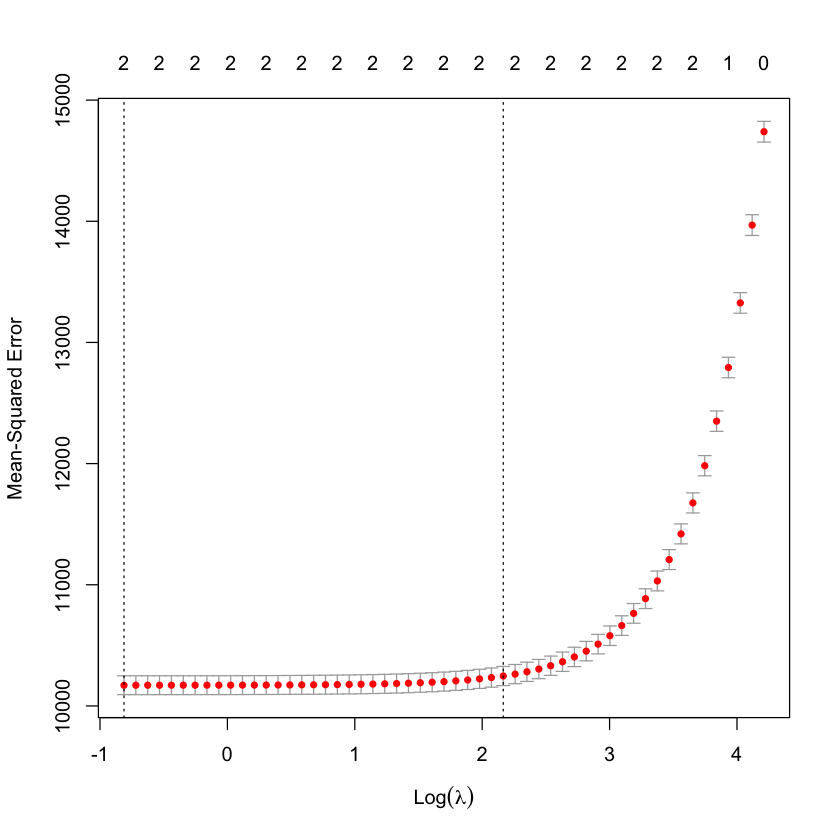

In [11]:
#Lasso
x <- model.matrix(euros_per_mwh ~ is_business + lowest_price_per_mwh + installed_capacity + eic_count  +  county + product_type + highest_price_per_mwh, data = df)
y <- df$euros_per_mwh
lasso_model <- cv.glmnet(x, y, alpha = 1)
plot(lasso_model)
best_lambda <- lasso_model$lambda.min
best_lambda
lasso_coefs <- coef(lasso_model, s = best_lambda)
lasso_coefs

[1] 12.14167

9 x 1 sparse Matrix of class "dgCMatrix"
                                 s1
(Intercept)            3.539712e+00
(Intercept)            .           
euros_per_mwh          8.758966e-01
lowest_price_per_mwh   7.598967e-02
installed_capacity     8.083028e-07
eic_count             -5.718000e-05
county                 1.178589e-03
product_type           2.503098e-02
highest_price_per_mwh  8.022109e-02

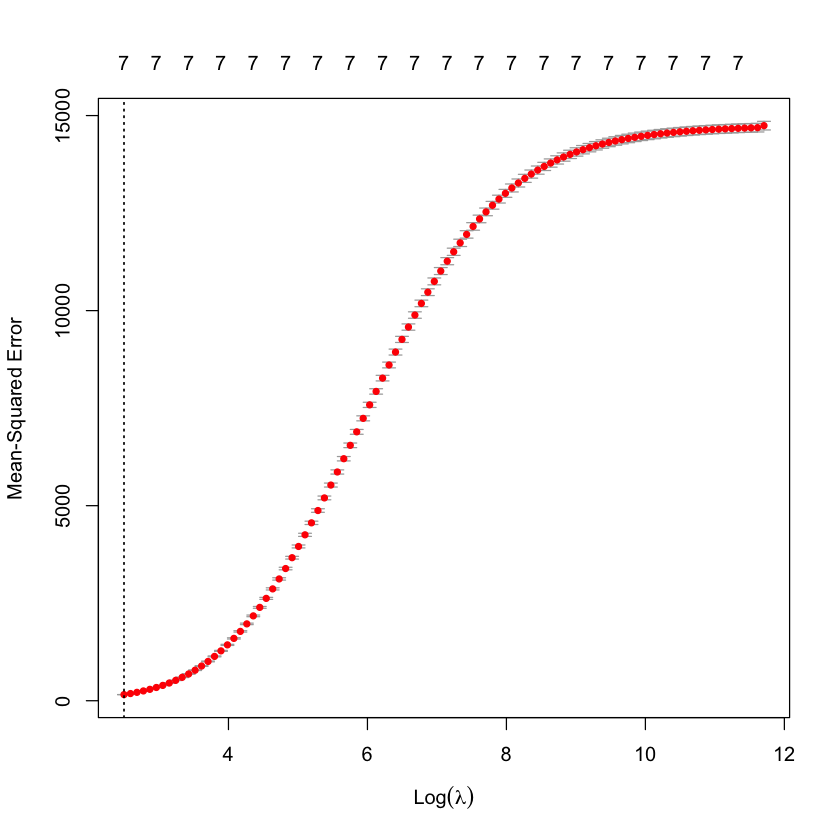

[1] 0.444118

9 x 1 sparse Matrix of class "dgCMatrix"
                              s1
(Intercept)           23.4089707
(Intercept)            .        
is_business            .        
lowest_price_per_mwh   0.4255586
installed_capacity     .        
eic_count              .        
county                 .        
product_type           .        
highest_price_per_mwh  0.8621229

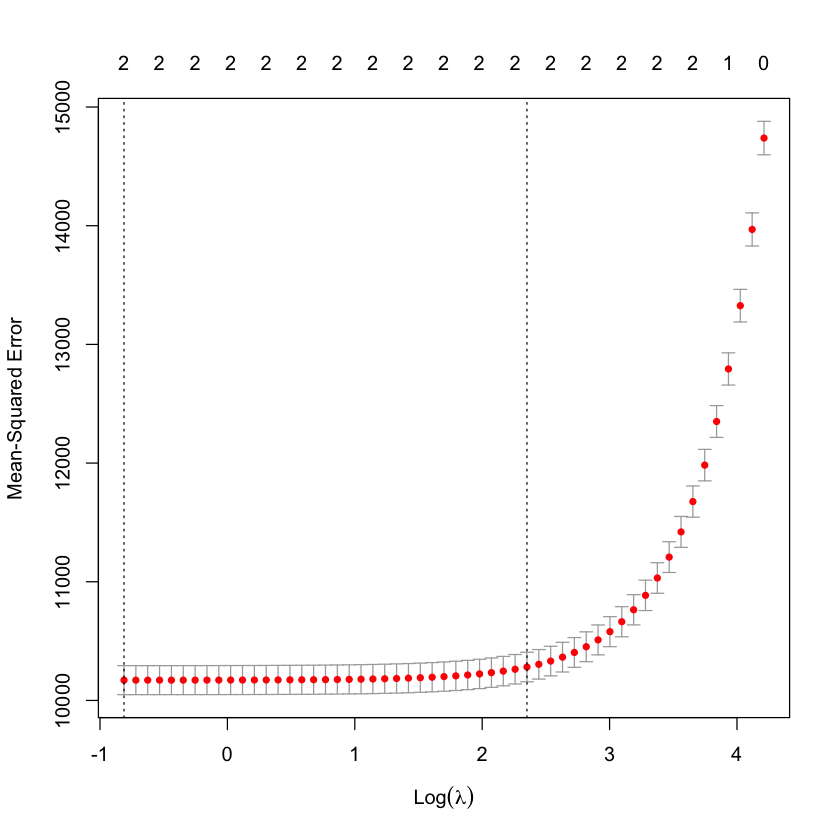

In [12]:
# Ridge (alpha=0)
x_logistic <- model.matrix(is_business ~ euros_per_mwh + lowest_price_per_mwh + installed_capacity + eic_count  +  county + product_type + highest_price_per_mwh, data = df)
ridge_model_logistic <- cv.glmnet(x_logistic, y, alpha = 0)
plot(ridge_model_logistic)
best_lambda_logistic <- ridge_model_logistic$lambda.min
best_lambda_logistic
ridge_coefs_logistic <- coef(ridge_model_logistic, s = best_lambda_logistic)
ridge_coefs_logistic

# Ridge (alpha=0) - linear model
x_linear <- model.matrix(euros_per_mwh ~ is_business + lowest_price_per_mwh + installed_capacity + eic_count  +  county + product_type + highest_price_per_mwh, data = df)
ridge_model_linear <- cv.glmnet(x_linear, y)
plot(ridge_model_linear)
best_lambda_linear <- ridge_model_linear$lambda.min
best_lambda_linear
ridge_coefs_linear <- coef(ridge_model_linear, s = best_lambda_linear)
ridge_coefs_linear


### LDA / QDA

In [16]:
# LDA
lda <- lda(is_business ~ euros_per_mwh + lowest_price_per_mwh + installed_capacity + eic_count + county + product_type + highest_price_per_mwh, data = df)
print(lda)

qda <- qda(is_business ~ euros_per_mwh + lowest_price_per_mwh + installed_capacity + eic_count + county + product_type + highest_price_per_mwh, data = df)
print(qda)

Call:
lda(is_business ~ euros_per_mwh + lowest_price_per_mwh + installed_capacity + 
    eic_count + county + product_type + highest_price_per_mwh, 
    data = df)

Prior probabilities of groups:
        0         1 
0.4632273 0.5367727 

Group means:
  euros_per_mwh lowest_price_per_mwh installed_capacity eic_count   county
0      157.1564             95.17206           1267.700 113.46240 7.161602
1      157.8121             95.83925           1608.749  38.72339 7.414031
  product_type highest_price_per_mwh
0     2.001545              107.9380
1     1.810502              108.7805

Coefficients of linear discriminants:
                                LD1
euros_per_mwh         -4.243005e-05
lowest_price_per_mwh  -1.515436e-03
installed_capacity     6.205327e-04
eic_count             -1.162763e-02
county                 4.508450e-03
product_type          -1.977076e-01
highest_price_per_mwh  1.594215e-03
Call:
qda(is_business ~ euros_per_mwh + lowest_price_per_mwh + installed_capacity + 


### Neural Network